In [1]:
%matplotlib qt5
import mne
from math import sqrt
import numpy

In [2]:
raw = mne.io.read_raw_brainvision('Sample_files/jkdz_wlk_20180728_open.vhdr', preload=True)
raw.set_montage(mne.channels.read_montage("standard_1020"))
raw_tmp = raw.copy()

Extracting parameters from Sample_files/jkdz_wlk_20180728_open.vhdr...
Setting channel info structure...
Reading 0 ... 942999  =      0.000 ...   188.600 secs...


<ipython-input-2-13c695835550>:1: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_brainvision('Sample_files/jkdz_wlk_20180728_open.vhdr', preload=True)


Used Annotations descriptions: []


<ipython-input-2-13c695835550>:2: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
  raw.set_montage(mne.channels.read_montage("standard_1020"))


In [3]:
raw_tmp.filter(1, None, fir_design="firwin")

Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 16501 samples (3.300 sec) selected


<RawBrainVision  |  jkdz_wlk_20180728_open.eeg, n_channels x n_times : 65 x 943000 (188.6 sec), ~467.8 MB, data loaded>

In [4]:
ica = mne.preprocessing.ICA(method="fastica")
ica.fit(raw_tmp, stop=raw.times[-1])

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 64
Fitting ICA took 257.6s.


<ICA  |  raw data decomposition, fit (fastica): 942999 samples, 64 components, channels used: "eeg">

In [ ]:
# 以上为之前任务

In [5]:
# 加载眼电模型
model = numpy.loadtxt('eeg_eyemvmt_model.csv')

In [6]:
# 定义检验标准
class compare():
    def __init__(self, model, data):
        self.model = model  # 加载模型数据
        self.data = data  # 加载待分析数据
        self.count = self.fitcount(self.model, self.data)  # 计算符合模型的区间个数

    # 皮尔逊相关系数
    def pearson(self, T1, T2, cnt):
        sum1 = sum(T1)
        sum2 = sum(T2)
        sqSum1 = sum(pow(num, 2) for num in T1)
        sqSum2 = sum(pow(num, 2) for num in T2)
        mulSum = sum(T1[i] * T2[i] for i in range(cnt))
        son = mulSum - sum1 * sum2 / cnt
        mot = sqrt((sqSum1 - pow(sum1, 2) / cnt) * (sqSum2 - pow(sum2, 2) / cnt))
        if mot == 0:
            r = 0
        else:
            r = son / mot
        return r

    def fitcount(self, train, data):
        count = 0
        i = 0
        while (len(data) - i) >= len(train):
            d = data[i:i + len(train)]
            if (max(d) - min(d)) / 2 > 2:  # 振幅大于2才检验，提高效率
                train_tmp = train * (max(d) - min(d)) / 2
                # 振动既可能先下后上，也可能先上后下
                r = max(self.pearson(train_tmp, d, len(train_tmp)), self.pearson(-train_tmp, d, len(train_tmp)))
                if r > 0.8:  # 相关系数阈值设定
                    count += 1
                    print('r', r)
                    i += len(train)
                    continue
            i += int(len(train) / 2)
            # 如果通过检验就跳过全部，否则只跳过一半，减小误差
        return count

In [7]:
# 提取原始数据信息
sample = ica.get_sources(inst=raw_tmp, start=0, stop=raw_tmp.times[-1]).get_data().copy()

In [8]:
content = []
for i in range(64):
    content.append(compare(model, sample[i]).count)
    print(i)
    if content[-1] > 5:  # 通过检验数大于5即可接受
        break
bad_eog = len(content) - 1
print('bad_eog is {}'.format(bad_eog))

0
1
2
3
4
r 0.9199523227678204
r 0.9055724335742171
r 0.9462493154504729
r 0.9399336642307387
r 0.8473859411382276
r 0.9334120744966303
r 0.9186960376804276
r 0.8877601779891314
r 0.837404722579581
r 0.9126659603545749
r 0.8214496948562316
r 0.8716362036658034
r 0.8985734198774772
r 0.8708500583703507
r 0.9094616941780912
r 0.9296060765596826
5
bad_eog is 5


In [ ]:
# 以下检验bad_eog的正确性

In [ ]:
ica.plot_components(inst=raw_tmp)

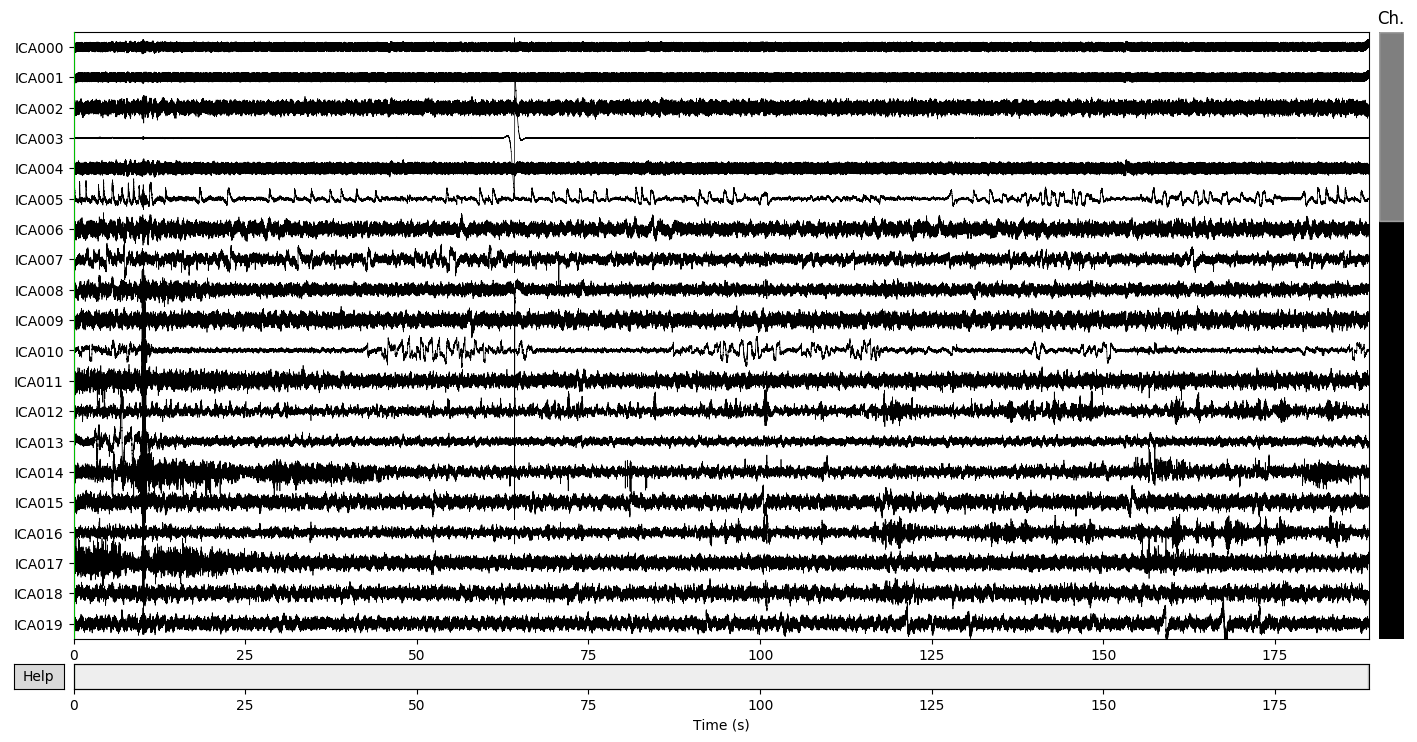

In [9]:
ica.plot_sources(inst=raw_tmp, start=0, stop=raw_tmp.times[-1])

In [ ]:
# 很准确

In [ ]:
# 以下为之前工作

In [10]:
ica.exclude = [bad_eog]

In [11]:
raw_corrected = raw.copy()
raw_corrected

<RawBrainVision  |  jkdz_wlk_20180728_open.eeg, n_channels x n_times : 65 x 943000 (188.6 sec), ~467.8 MB, data loaded>

In [12]:
ica.apply(raw_corrected)

Transforming to ICA space (64 components)
Zeroing out 1 ICA components


<RawBrainVision  |  jkdz_wlk_20180728_open.eeg, n_channels x n_times : 65 x 943000 (188.6 sec), ~467.8 MB, data loaded>

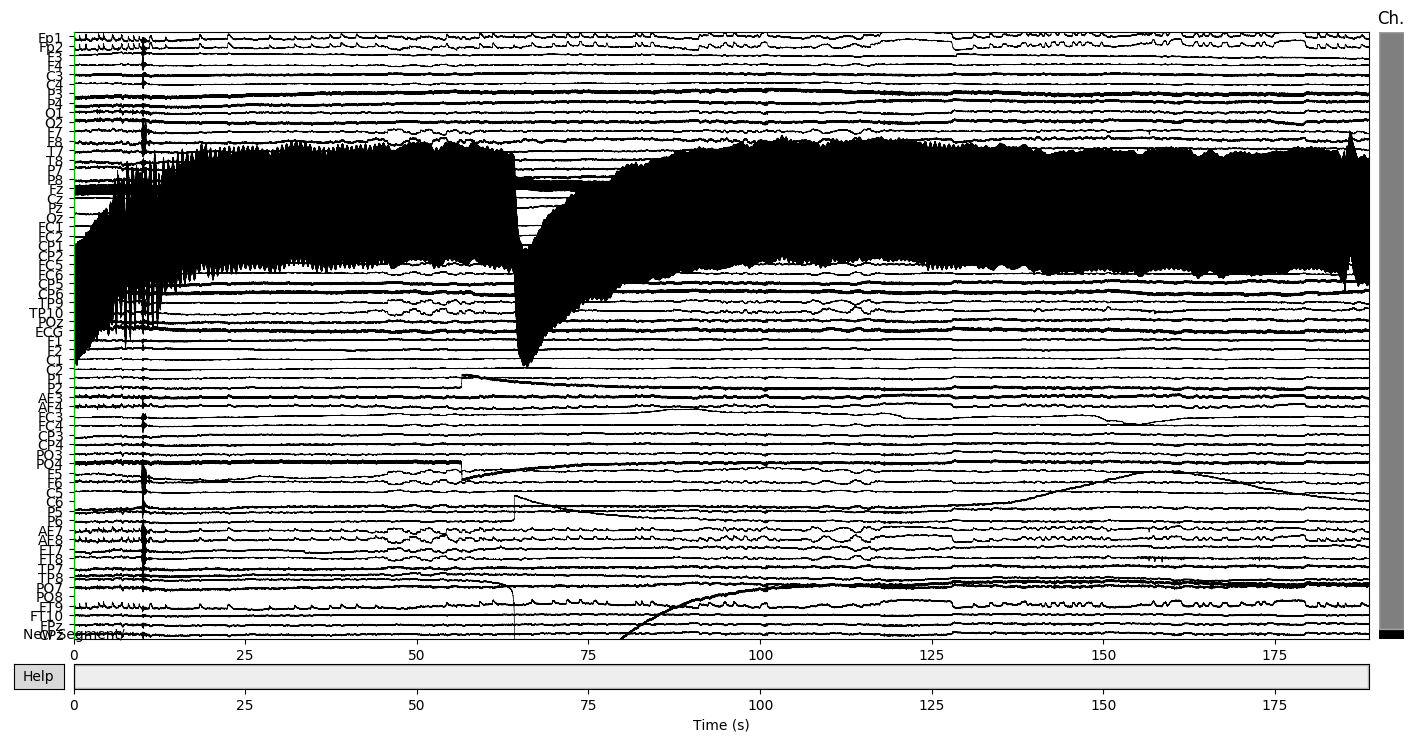

In [13]:
raw.plot(n_channels=64, start=0, duration=raw.times[-1], scalings=dict(eeg=2e-4))

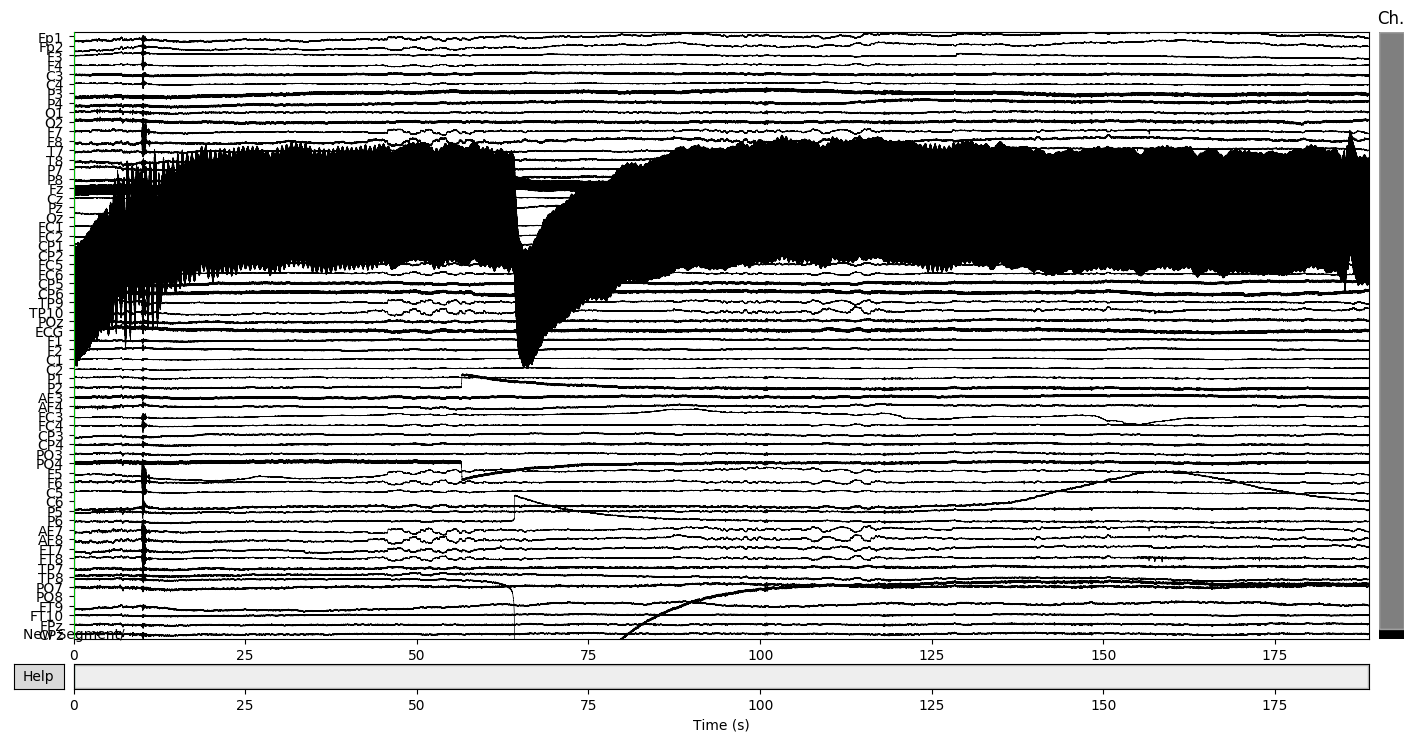

In [14]:
raw_corrected.plot(n_channels=64, start=0, duration=raw_corrected.times[-1], scalings=dict(eeg=2e-4))

In [ ]:
# 眼电伪迹消除效果很明显

In [ ]:
# 总结：
# 经过各种尝试，最终发现这种方式效果最好，通过拟合找到特征峰，结果突出，准确度高
# 但也不能避免会出现差错（曾经测试到过），相比来说判断相关性的过程，耗时较长，有待改进